# RatV Day1NSD recording info

In [10]:
import numpy as np
import subjects

sess = subjects.nsd.ratVday1[0] # add your subject session
print(sess.recinfo)

filename: /data/Clustering/sessions/RatV/RatVDay1NSD/RatV_Day1NSD_2021-10-02_08-10-23.xml 
# channels: 264
sampling rate: 30000
lfp Srate (downsampled): 1250



# Animal metadata

In [ ]:
from neuropy.core import animal

d = {'name':'hello','tag':'ser'}

an = animal.Animal(d) 


# Probe configuration
- Add text for details about the probes that were used

## A simple 8 shank probe with same layout across all shanks

In [ ]:
%matplotlib widget
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0, -15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

shanks = []
for i in range(8,16):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0, -15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.save(sess.filePrefix.with_suffix(".probegroup.npy"))
plot_probe(prbgrp)



## Create Probemap for spyking circus

In [ ]:
from neuropy.utils import probe_util

probe_util.write_spyking_circus(
    file=sess.filePrefix.with_suffix(".prb"), prb=sess.probegroup, combine_shanks=True
)

# Experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [ ]:
import pandas as pd
from neuropy.core import Epoch

datetime_data = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
durations = datetime_data.nFrames/sess.recinfo.dat_sampling_rate
epochs = pd.DataFrame(
    {
        "start": [0,10147,13272,45723],
        "stop": [10145,13271,45722,48886],
        "label": ["pre", "maze",'post','re-maze'],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.filename = sess.filePrefix.with_suffix(".paradigm.npy")
paradigm.save()

# Neurons
- import spiketrains from Phy
- estimate neuron types such pyramidal, interneuron etc. 

## Importing spiketrains from Phy

### Single folder

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/home/bapung/Documents/ClusteringHub/spykcirc/RatV/RatVDay1NSD/RatV_Day1NSD_2021-10-02_08-10-23-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id < 4] = "pyr"
neuron_type[neuron_type_id == 6] = "mua"
neuron_type[neuron_type_id == 8] = "inter"


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms, dtype="object"),
    neuron_type=neuron_type,
    shank_ids=np.array(shank_id).astype(int),
    metadata={'cluster_path':str(cluster_path)}
)

neurons.save(sess.filePrefix.with_suffix(".neurons"))

### Plot raster

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster

plot_raster(neurons,color='jet',add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
from neuropy import analyses 

signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7,boundary=2)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()

In [ ]:
%matplotlib widget
from neuropy import plotting
signal = sess.eegfile.get_signal([1])
plotting.plot_artifact_epochs(sess.artifact, signal)

### export for spyking circus

In [ ]:
from neuropy.io import SpykingCircusIO

SpykingCircusIO.write_epochs(sess.filePrefix.with_suffix('.dead'),sess.artifact)

## Ripple
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

## Pbe

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=1)

In [ ]:
import pandas as pd
from datetime import datetime

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    # sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S")
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix(".position.npy"))


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(position.x,position.y)

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([40])

spec = signal_process.spectrogramBands(signal.traces[0])


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/500)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.y)*100)
plt.xlim([12500,12600])
plt.ylim([-400,400])

### Linearize position

In [11]:
from neuropy.utils import position_util

maze = sess.paradigm['maze'].flatten()
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix('.maze.linear'))

/data/Clustering/sessions/RatV/RatVDay1NSD/RatV_Day1NSD_2021-10-02_08-10-23.maze.linear saved


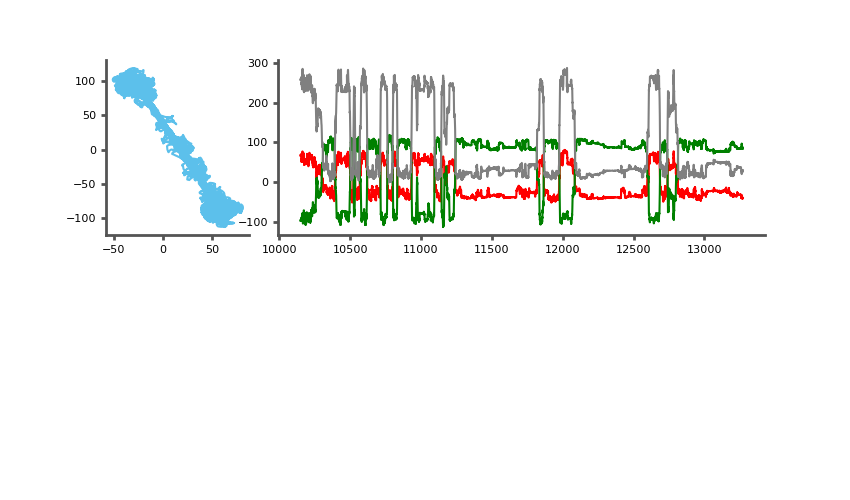

In [12]:
%matplotlib widget
from neuropy import plotting

fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'gray')